In [1]:
import pandas as pd
import numpy as np

# Load data from Kaggle preloaded input
train_df = pd.read_csv("/kaggle/input/summer-analytics-mid-hackathon/hacktrain.csv")
test_df = pd.read_csv("/kaggle/input/summer-analytics-mid-hackathon/hacktest.csv")

# Separate metadata
y_train = train_df['class']
train_ids = train_df['ID']
test_ids = test_df['ID']

# Drop non-NDVI columns
X_train_raw = train_df.drop(columns=['ID', 'class'])
X_test_raw = test_df.drop(columns=['ID'])

# Combine train + test for consistent imputation
combined = pd.concat([X_train_raw, X_test_raw], axis=0, ignore_index=True)

# Interpolate missing values (NDVI time-series)
combined = combined.interpolate(method='linear', axis=1, limit_direction='both')

# Fill remaining missing values with seasonal forward-fill
# Replaced combined.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
# with the recommended ffill() and bfill() methods to avoid FutureWarning.
combined = combined.ffill(axis=1).bfill(axis=1)

# Separate back
X_train_imputed = combined.iloc[:len(X_train_raw)].reset_index(drop=True)
X_test_imputed = combined.iloc[len(X_train_raw):].reset_index(drop=True)

# Save for future steps
X_train_imputed.to_csv("/kaggle/working/X_train_imputed_v2.csv", index=False)
X_test_imputed.to_csv("/kaggle/working/X_test_imputed_v2.csv", index=False)
y_train.to_csv("/kaggle/working/y_train_v2.csv", index=False)
test_ids.to_csv("/kaggle/working/test_IDs_v2.csv", index=False)

print("✅ Step 1 complete: Interpolated NDVI data saved.")


✅ Step 1 complete: Interpolated NDVI data saved.


In [2]:
# 2_feature_engineering_v2.ipynb
import pandas as pd
import numpy as np

# Load imputed NDVI data
X_train = pd.read_csv("/kaggle/working/X_train_imputed_v2.csv")
X_test = pd.read_csv("/kaggle/working/X_test_imputed_v2.csv")

# Drop index column if present
if 'Unnamed: 0' in X_train.columns:
    X_train = X_train.drop(columns=['Unnamed: 0'])
if 'Unnamed: 0' in X_test.columns:
    X_test = X_test.drop(columns=['Unnamed: 0'])

# Function to extract engineered features from NDVI time series
def generate_features(df):
    features = pd.DataFrame()
    features['mean'] = df.mean(axis=1)
    features['std'] = df.std(axis=1)
    features['min'] = df.min(axis=1)
    features['max'] = df.max(axis=1)
    features['range'] = features['max'] - features['min']
    features['median'] = df.median(axis=1)
    features['q25'] = df.quantile(0.25, axis=1)
    features['q75'] = df.quantile(0.75, axis=1)
    features['skew'] = df.skew(axis=1)
    features['kurt'] = df.kurtosis(axis=1)

    # Dynamic features
    features['ndvi_slope'] = df.iloc[:, -1] - df.iloc[:, 0]  # start to end trend
    features['peak_ndvi'] = df.max(axis=1)
    features['peak_pos'] = df.idxmax(axis=1).apply(lambda x: int(x.split('_')[0]) if isinstance(x, str) and '_' in x else 0)

    # FFT features (frequency domain)
    fft_vals = np.abs(np.fft.fft(df.values, axis=1))[:, 1:4]  # skip the DC component
    for i in range(3):
        features[f'fft_{i+1}'] = fft_vals[:, i]

    return features

# Extract features
X_train_features = generate_features(X_train)
X_test_features = generate_features(X_test)

# Save engineered features
X_train_features.to_csv("/kaggle/working/X_train_features_v2.csv", index=False)
X_test_features.to_csv("/kaggle/working/X_test_features_v2.csv", index=False)

print("✅ Step 2 complete: Feature-engineered datasets saved.")


✅ Step 2 complete: Feature-engineered datasets saved.


In [3]:
# 3_logistic_regression_model_v2.ipynb
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import joblib

# Load data
X = pd.read_csv("/kaggle/working/X_train_features_v2.csv")
y = pd.read_csv("/kaggle/input/summer-analytics-mid-hackathon/hacktrain.csv")["class"]
X_test = pd.read_csv("/kaggle/working/X_test_features_v2.csv")

# Encode target labels
y_le = LabelEncoder()
y_encoded = y_le.fit_transform(y)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

# PCA for dimensionality reduction (retain 95% variance)
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Train/Validation split
X_train, X_val, y_train, y_val = train_test_split(X_pca, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Train Logistic Regression
clf = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial')
clf.fit(X_train, y_train)

# Validation Accuracy
y_val_pred = clf.predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_acc:.4f}")

# Retrain on full training set
clf.fit(X_pca, y_encoded)

# Predict on test set
y_test_pred = clf.predict(X_test_pca)
y_test_labels = y_le.inverse_transform(y_test_pred)

# Create submission file
submission_df = pd.read_csv("/kaggle/input/summer-analytics-mid-hackathon/hacktest.csv")[['ID']]
submission_df['class'] = y_test_labels
submission_df.to_csv("/kaggle/working/submission.csv", index=False)

# Save model for reuse
joblib.dump(clf, "/kaggle/working/logistic_model_v2.joblib")
joblib.dump(pca, "/kaggle/working/pca_transform_v2.joblib")
joblib.dump(scaler, "/kaggle/working/standard_scaler_v2.joblib")

print("✅ Step 3 complete: Model trained, validated, and predictions saved to submission.csv")


Validation Accuracy: 0.8581
✅ Step 3 complete: Model trained, validated, and predictions saved to submission.csv


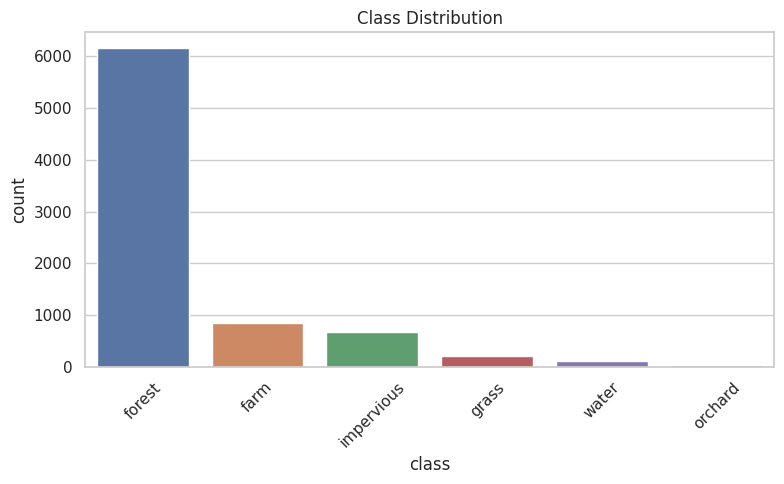

/tmp/ipykernel_13/3433043021.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby("class").apply(lambda x: x.sample(3, random_state=42)).reset_index(drop=True)


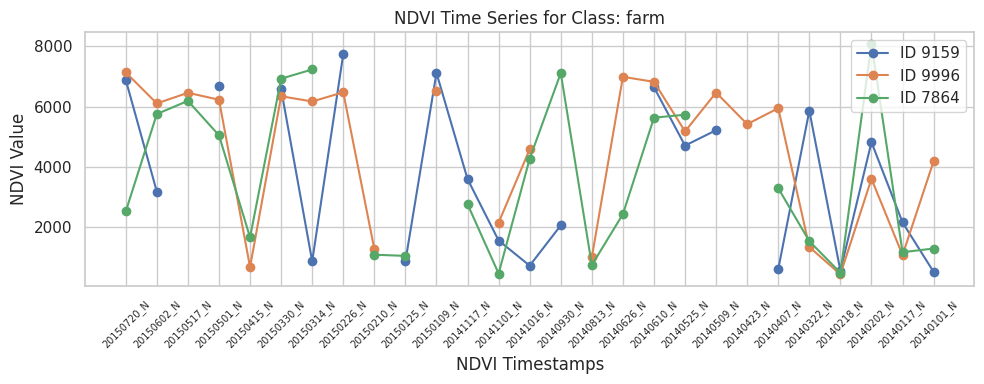

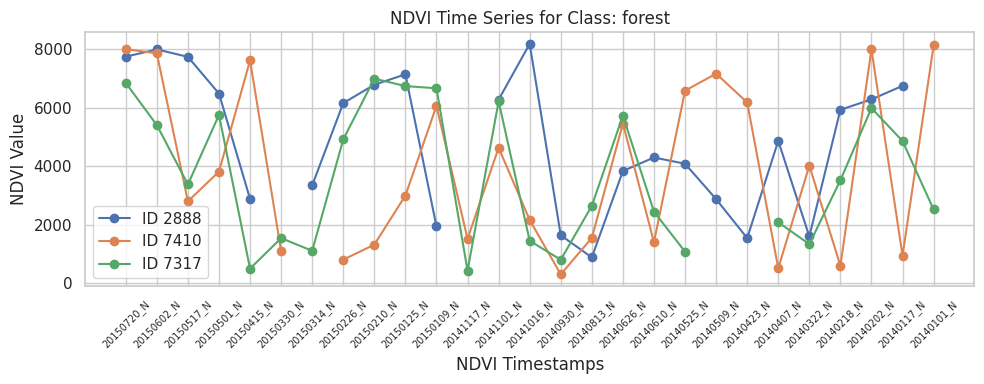

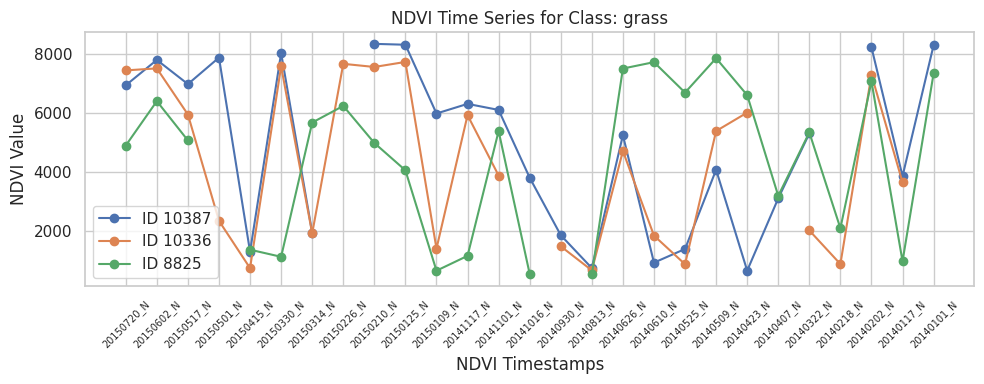

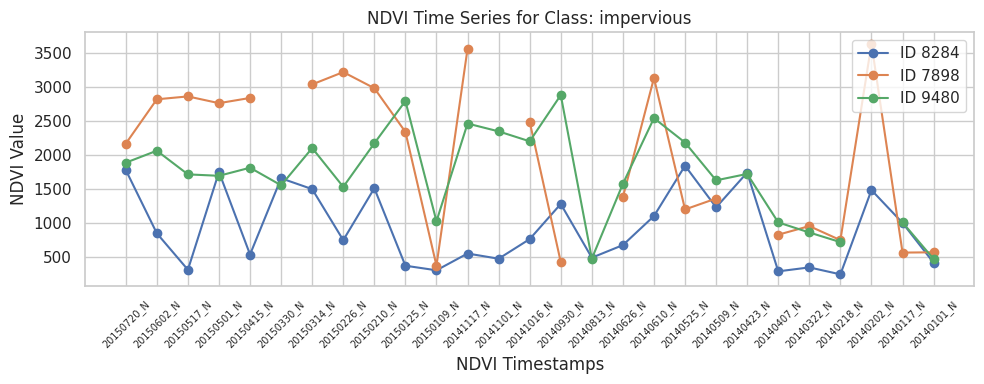

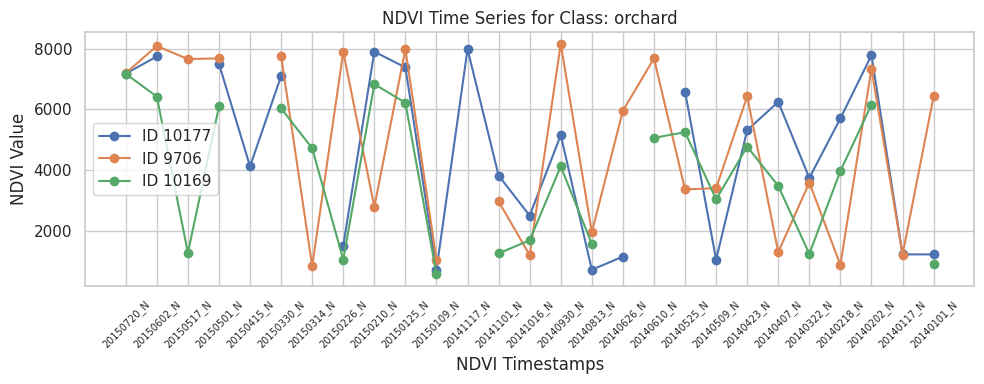

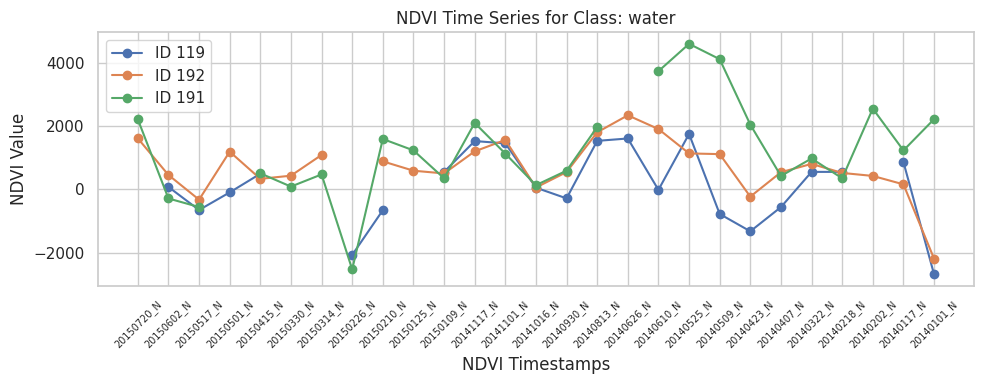

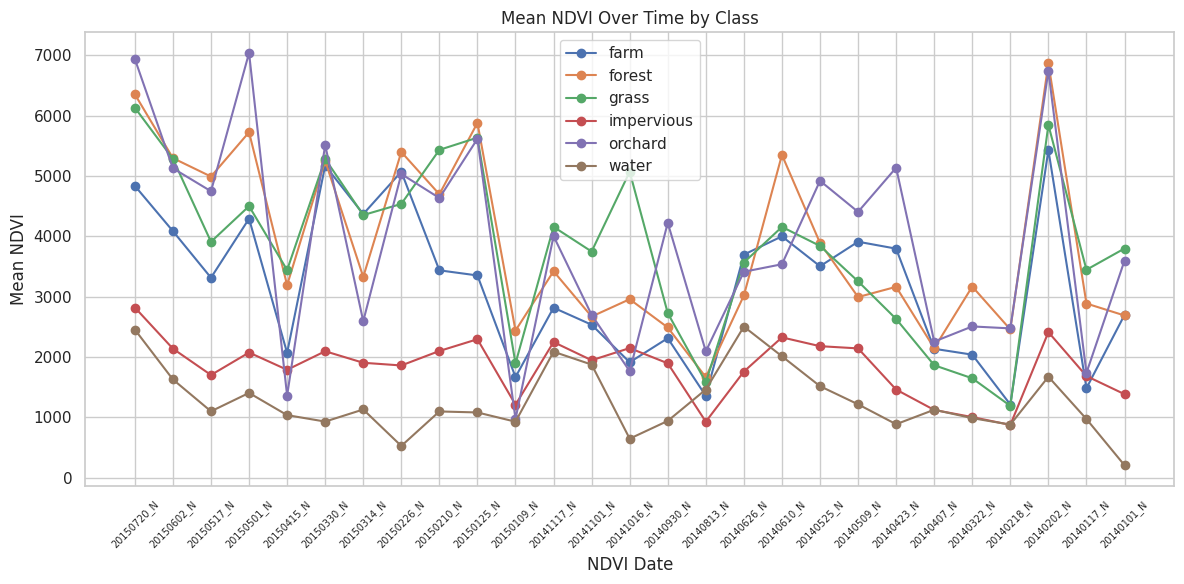

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


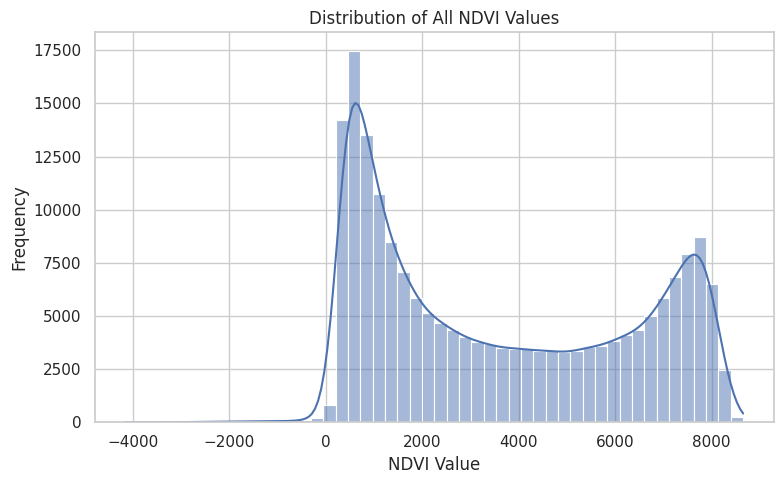

✅ Step 4 complete: EDA with visualizations generated.


In [4]:
# 4_exploratory_data_analysis.ipynb

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for plots
sns.set(style="whitegrid")

# Load raw training data (includes class labels and NDVI time series)
df = pd.read_csv("/kaggle/input/summer-analytics-mid-hackathon/hacktrain.csv")

# Extract NDVI columns and class labels
ndvi_cols = [col for col in df.columns if col.endswith('_N')]
df_ndvi = df[ndvi_cols + ['class']]

# --- 1. Class Distribution ---
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='class', order=df['class'].value_counts().index)
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- 2. NDVI Time Series Example Plots ---
# Sample 3 points from each class
sampled_df = df.groupby("class").apply(lambda x: x.sample(3, random_state=42)).reset_index(drop=True)

# Plot time series for each sample
for cls in sampled_df['class'].unique():
    subset = sampled_df[sampled_df['class'] == cls]
    plt.figure(figsize=(10, 4))
    for i, row in subset.iterrows():
        plt.plot(ndvi_cols, row[ndvi_cols], marker='o', label=f"ID {row['ID']}")
    plt.title(f"NDVI Time Series for Class: {cls}")
    plt.xlabel("NDVI Timestamps")
    plt.ylabel("NDVI Value")
    plt.xticks(rotation=45, fontsize=7)
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- 3. Mean NDVI Trend per Class ---
class_means = df_ndvi.groupby('class').mean().T
plt.figure(figsize=(12, 6))
for cls in class_means.columns:
    plt.plot(class_means.index, class_means[cls], marker='o', label=cls)
plt.title("Mean NDVI Over Time by Class")
plt.xlabel("NDVI Date")
plt.ylabel("Mean NDVI")
plt.xticks(rotation=45, fontsize=7)
plt.legend()
plt.tight_layout()
plt.show()

# --- 4. NDVI Distribution Histogram (Overall) ---
all_ndvi_values = df[ndvi_cols].values.flatten()
plt.figure(figsize=(8, 5))
sns.histplot(all_ndvi_values, bins=50, kde=True)
plt.title("Distribution of All NDVI Values")
plt.xlabel("NDVI Value")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

print("✅ Step 4 complete: EDA with visualizations generated.")